In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast
from scipy.signal import butter, filtfilt
from scipy.stats import kurtosis,skew

In [11]:
#defenition of data path and excel file path
path = '/home/abhishek/rashad_internship/dataset/physionet.org/files/ptb-xl/1.0.3/'

In [23]:
import ast
import pandas as pd
import wfdb
import numpy as np
from scipy.signal import butter, filtfilt
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class Custom_class(Dataset):
    def __init__(self, path, num_data, transform=None, data_split='train', fold=10):
        self.dat = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
        self.statements = pd.read_csv(path + 'scp_statements.csv', index_col=0)
        self.statements = self.statements[self.statements.diagnostic == 1]
        self.dat.index = self.dat.index.astype(int)
        self.dat.index = self.dat.reindex(range(0, 21799))
        
        # Add diagnostic superclass
        self.dat.scp_codes = self.dat.scp_codes.apply(lambda x: ast.literal_eval(x))
        self.diagnostic_classes = ['NORM', 'STTC', 'MI', 'HYP', 'CD']
        self.dat['diagnostic_superclass'] = self.dat.scp_codes.apply(self.aggregate_diagnostic)
        
        self.col = self.dat['filename_hr']  # only 500 hz files are used for training
        self.label = self.dat['scp_codes']  # used for labeling
        self.superclass_label = self.dat['diagnostic_superclass']  # diagnostic superclass label
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.data_split = data_split
        self.fold = fold
        
        if self.data_split == 'train':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] <= self.fold)]
        elif self.data_split == 'test':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == self.fold)]
        elif self.data_split == 'val':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == self.fold)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        
        try:
            y, _ = wfdb.rdsamp(self.path + self.col[idx])  # Use channel 0
        except Exception as e:
            print(f"Error loading data at index {idx}: {str(e)}")
            return None
        
        y = y.astype(np.float32)
        y = np.transpose(y)  # changing dimension from 5000, 12 to 12, 5000

        # Apply filtering
        y = self.bandpass_filter(y, 1, 47, 500)  # applying BPF

        # Normalize using z-score
        y = self.z_score_normalize(y)
        y = y.astype(np.float32)

        # Get the diagnostic superclass label
        superclass_list = self.superclass_label[idx]
        label = np.zeros(len(self.diagnostic_classes), dtype=np.float32)
        # Select the first label from the list (or apply your own logic here)
        if superclass_list:
            label[self.diagnostic_classes.index(superclass_list[0])]=1

        if self.transform:
            y = self.transform(y)

        return y[0, :, :], label

    def bandpass_filter(self, data, lowcut, highcut, fs, order=3):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data, axis=1)
        return y

    def z_score_normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        normalized_data = (data - mean) / std
        return normalized_data

    def aggregate_diagnostic(self, y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in self.statements.index:
                tmp.append(self.statements.loc[key].diagnostic_class)
        return tmp  # Return list of diagnostic classes
    
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [24]:
train_dataset = Custom_class( path, num_data=12000, transform=transform, data_split='train', fold=8)
val_dataset = Custom_class( path, num_data=12000, transform=transform, data_split='val', fold=9)
test_dataset = Custom_class( path, num_data=12000, transform=transform, data_split='test', fold=8)


In [25]:
print(train_dataset[1211])

(tensor([[ 0.0204,  0.0185,  0.0172,  ..., -0.0080, -0.0078, -0.0075],
        [ 0.0783,  0.0798,  0.0812,  ...,  0.0320,  0.0290,  0.0262],
        [ 0.0198,  0.0227,  0.0248,  ...,  0.0257,  0.0239,  0.0221],
        ...,
        [ 0.1970,  0.1969,  0.1971,  ...,  0.0445,  0.0426,  0.0407],
        [ 0.0070,  0.0039,  0.0009,  ...,  0.0084,  0.0080,  0.0076],
        [-0.0626, -0.0664, -0.0704,  ..., -0.0016, -0.0013, -0.0010]]), 2)


In [26]:
print(f"Number of data in training set : {len(train_dataset)}")
print(f"Number of data in validation set :{len(val_dataset)}")
print(f"Number of data in Test set :{len(test_dataset)}")


Number of data in training set : 9359
Number of data in validation set :1325
Number of data in Test set :1137


In [27]:
#MODEL DEFINITION
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.stats import skew, kurtosis

def signal_statistics(signal):
    variance = np.var(signal)
    signal_skewness = skew(signal)
    signal_kurtosis = kurtosis(signal)

    return variance, signal_skewness, signal_kurtosis


# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 128, 1)
        self.layer2 = self._make_layer(ResBlock2, 128, 128, 2)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 1)
        self.layer4 = self._make_layer(ResBlock2, 256, 256, 3)
        self.layer5 = self._make_layer(ResBlock1, 256, 512, 1)
        self.layer6 = self._make_layer(ResBlock2, 512, 512, 5)
        self.layer7 = self._make_layer(ResBlock1, 512, 1024, 1)
        self.layer8 = self._make_layer(ResBlock2, 1024, 1024, 2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5) #added to improve generalization
        self.fc1 = nn.Linear(1027, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 5)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, stat_features):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = torch.cat((x, stat_features), dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        # x = F.sigmoid(x)  # Use softmax for multi-class classification
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=6)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)


cuda


In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2)

In [29]:
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(epoch):
    if epoch < 10:
        return 1.0
    else:
        return math.exp(-1)



In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from scipy.stats import skew, kurtosis
import wandb

# Initialize W&B
wandb.init(project="ECG_MULTI_CLASS")

# Define your optimizer and scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define your data loaders (train_dataloader, validation_dataloader)

num_epochs = 35
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Define your validation function
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            inputs_np = inputs.cpu().numpy()
            mean = torch.tensor(np.mean(inputs_np, axis=2)).float().to(device)
            skewness = torch.tensor(skew(inputs_np, axis=2)).float().to(device)
            kurt = torch.tensor(kurtosis(inputs_np, axis=2)).float().to(device)
            mean_of_means = torch.mean(mean, dim=1)  # Size 12, representing mean of means across the batch
            mean_of_skewness = torch.mean(skewness, dim=1)  # Size 12, representing mean of skewness across the batch
            mean_of_kurtosis = torch.mean(kurt, dim=1) 
            # stat_features = torch.stack((mean, skewness, kurt), dim=1)
            stat_features = torch.stack((mean_of_means, mean_of_skewness, mean_of_kurtosis), dim=1)

            # Forward pass
            outputs = model(inputs, stat_features)
            
            preds = torch.argmax(outputs, dim=1)  # Get the index of the max value in the output
            labelss = torch.argmax(labels, dim=1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labelss.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        inputs_np = inputs.cpu().numpy()
        mean = torch.tensor(np.mean(inputs_np, axis=2)).float().to(device)
        skewness = torch.tensor(skew(inputs_np, axis=2)).float().to(device)
        kurt = torch.tensor(kurtosis(inputs_np, axis=2)).float().to(device)
        mean_of_means = torch.mean(mean, dim=1)  # Size 12, representing mean of means across the batch
        mean_of_skewness = torch.mean(skewness, dim=1)  # Size 12, representing mean of skewness across the batch
        mean_of_kurtosis = torch.mean(kurt, dim=1)      # Size 12, representing mean of kurtosis across the batch

        stat_features = torch.stack((mean_of_means, mean_of_skewness, mean_of_kurtosis), dim=1)

        # Forward pass
        outputs = model(inputs, stat_features)
        preds = torch.argmax(outputs, dim=1)  # Get the index of the max value in the output
        labelss = torch.argmax(labels, dim=1)

        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labelss.data)
        
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    scheduler.step()

    # Log training metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "train_accuracy": epoch_acc
    })

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validate the model
    val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
    
    # Log validation metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Deep copy the model if the current validation accuracy is the best so far
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

# Load best model weights
model.load_state_dict(best_model_wts)

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

# End W&B run
wandb.finish()


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▂▂▃▃▆▇█
train_loss,██▇▇▇▆▆▃▂▁
val_accuracy,█▃▅▃▁▄▆▆▅▅
val_loss,▁▂▃▅▃▃▆▄▆█
epoch,10
train_accuracy,0.92318
train_loss,0.07598
val_accuracy,0.70415
val_loss,0.36034


Training - Epoch 1/35, Loss: 0.1308, Accuracy: 0.8643
Validation - Epoch 1/35, Loss: 0.3423, Accuracy: 0.7140
Training - Epoch 2/35, Loss: 0.1279, Accuracy: 0.8645
Validation - Epoch 2/35, Loss: 0.3332, Accuracy: 0.6996
Training - Epoch 3/35, Loss: 0.1234, Accuracy: 0.8715
Validation - Epoch 3/35, Loss: 0.3766, Accuracy: 0.6740
Training - Epoch 4/35, Loss: 0.1168, Accuracy: 0.8801
Validation - Epoch 4/35, Loss: 0.3860, Accuracy: 0.7064
Training - Epoch 5/35, Loss: 0.1109, Accuracy: 0.8850
Validation - Epoch 5/35, Loss: 0.3546, Accuracy: 0.7034
Training - Epoch 6/35, Loss: 0.1000, Accuracy: 0.8973
Validation - Epoch 6/35, Loss: 0.3726, Accuracy: 0.6951
Training - Epoch 7/35, Loss: 0.1036, Accuracy: 0.8949
Validation - Epoch 7/35, Loss: 0.3826, Accuracy: 0.6823
Training - Epoch 8/35, Loss: 0.0646, Accuracy: 0.9355
Validation - Epoch 8/35, Loss: 0.3824, Accuracy: 0.7125
Training - Epoch 9/35, Loss: 0.0402, Accuracy: 0.9606
Validation - Epoch 9/35, Loss: 0.4063, Accuracy: 0.7132
Training -

KeyboardInterrupt: 

In [21]:
import torch
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.metrics import accuracy_score, confusion_matrix

# Load your model class and initialize the model
# Assuming ResNet50 is your model class
model = ResNet50(input_channels=12, num_classes=6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('/home/abhishek/rashad_internship/ecg_classification_using_resnet/best_model.pth'))

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            
            # Calculate statistical features
            data_np = data.cpu().numpy()
            mean = torch.tensor(np.mean(data_np, axis=2)).float().to(device)
            skewness = torch.tensor(skew(data_np, axis=2)).float().to(device)
            kurt = torch.tensor(kurtosis(data_np, axis=2)).float().to(device)
            mean_of_means = torch.mean(mean, dim=1)  # Size 12, representing mean of means across the batch
            mean_of_skewness = torch.mean(skewness, dim=1)  # Size 12, representing mean of skewness across the batch
            mean_of_kurtosis = torch.mean(kurt, dim=1)  # Size 12, representing mean of kurtosis across the batch
            stat_features = torch.stack((mean_of_means, mean_of_skewness, mean_of_kurtosis), dim=1)

            # Forward pass
            outputs = model(data, stat_features)
            _, preds = torch.max(outputs, dim=1)
            _, labels = torch.max(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, confusion_matrix = test_model(model, test_dataloader)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.8979771328056289
Confusion Matrix:
[[506  25   9   0   1]
 [  3 146   1   0   1]
 [  3   8 239   0   0]
 [ 11  28   9  21   2]
 [  4   2   3   6 109]]


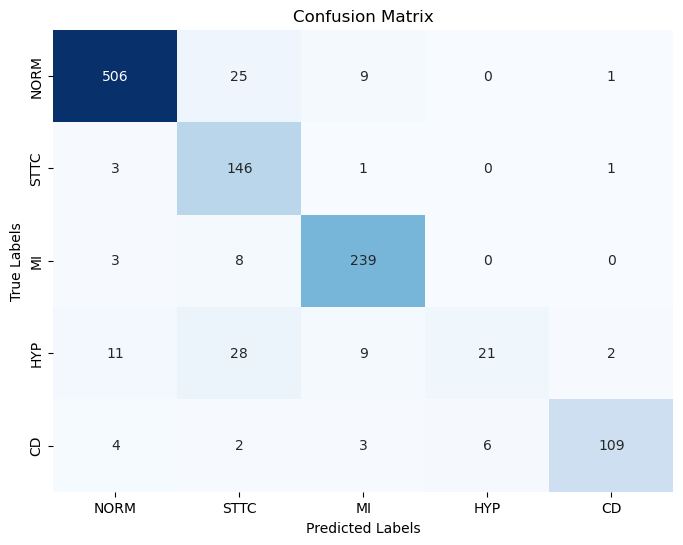

In [22]:
import seaborn as sns

class_names = ['NORM', 'STTC', 'MI', 'HYP', 'CD']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()